# Introduction

***Warning:*** This is the second notebook of this project. in the first one ("eda_and_feature_engineering"), we define the problem, explored the data, we did an initial treatment and created some features. I strongly recommend that you visit the first script before exploring this one, they are two parts of the same project, and were split just to avoid an extremely large script, improving the organization.

**Method:**

As mentioned, we have already pre-treated our data. However, the EDA revealed that we have ***unbalanced data***, we need to understand witch technique should be used to train our model. In order to build the best possible model, we also need to perform feature selection. 

All considered, we decided to opt for an iterative methodology, as described below:

+ Define and prepare metrics to be easily applicable 
+ Define functions to build a model (Random Forest and XGBoost) 
+ Define funtions to evaluate models with Stratified K-Folds cross-validator (avoiding data leakage)
+ Treat the imbalance data problem and choose the best technique
+ Feature selection and engineering
+ Model selection and hyperparameter tuning with grid search
+ Evaluate model performance with learning curve


# Libs

In [2]:
import pandas as pd 
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import xgboost
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# Metrics

**Defining metrics**

Evaluating a classification model may not be the easiest task. In order to obtain a consistent result it will be necessary to use a set of metrics, we will adopt:

+ recall -- Indicates the occurrence of false negative, e.g, predict indicated that default would NOT occur, but it did
+ precision -- Indicates rate at which positive predictions are correct, e.g, predict indicated that default would occur, and it did
    + Please note: in our case, **recall will have greater relevance**, because predicting a false negative will result in greater losses for the business than predicting a false positive
+ F1 -- A function of Precision and Recall. Even though Recall is more important, precision is also relevant, because wrongly predicting that a default will happen, also results in business loses. So it is good to have a metric that represents a balance between Precision and Recall. 
+ ROC Curve -- Until now, our metrics are considering 3 of 4 values of the confusion matrix, we are not looking at true negatives! We could use Accuracy or Specificity to include true negative in our analyses, but we expected that the majority of data will be true negative, so those metrics may be misleading. Instead, we will use the ROC curve, that shows the relation between  True Positive Rate and True Negative Rate. 
+ AUC -- Its the area under the ROC curve, it is a simple way to measure the ROC Curve.


***To make our life easier, we will define a class that calculates and displays all the desired metrics***

**Important:**

To make our notebook easier to read and our work more scalable, we created a class (Metrics) and functions that calculates metrics and show relevant charts. We put everything in a .py file (classification.py), and here, we will just import it. 

In [3]:
# Importing classification.py

import classification

***Please, check the file classification.py found in this same repository for better understanding***

# Building the model and Treating Imbalance

## Building pipeline functions and a Baseline 

Now that we we define and prepare our metrics, its time to develop the model! Following the logic defined in our method, we are going to create some functions to facilitate the definition of differents pipelines.

***The pipelines will:***
+ Receive the features as keywords (X,y)
+ Use StratifiedKFold cross validation technique to divide the data in 10 (or n) folds
    + We will use StratifiedKFold instead of normal K-fold  to preserve the percentage of samples for the target category in each fold.
+ Pre processing the training data ***(isolating test data to avoid overfitting)***. ps: Step not included in in the definition of baseline 
+ Build a Classifier model for each fold and make predictions with the validation data. 
+ Calculate metrics for each fold using our pre defined Metrics class, and display a summary of the results.

***This way, we can obtain a baseline with the original data, without any type of treatment, and as we process the data (treating imbalance and doing feature engineering) it will be easier to test our hypotheses and evaluate our improvement!***

In [4]:
def divide_kfolds(X,y,n = 10):
    
    """Return 4 lists containing training and validation data, divided in n Stratified KFolds

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    n -- Number of folds (default = 10)
    """

    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n, shuffle=True,random_state=42)

    X_train_list,X_test_list,y_train_list,y_test_list = [[] for i in range(4)]
    # Split features in folds
    for train_index, test_index in skf.split(X,y):

        X_train_list.append(X.loc[train_index])
        X_test_list.append(X.loc[test_index])
        y_train_list.append(y.loc[train_index])
        y_test_list.append( y.loc[test_index])

    return X_train_list, X_test_list, y_train_list,y_test_list
    

In [5]:
def evaluate_random_forest(X_train_list, X_test_list, y_train_list,y_test_list,# Train and validation data
                           n_est = 100,max_d = None, min_s_leaf = 1, min_s_split = 2, # hyperparameters
                           charts =1,metrics = 1, val =1 # Others
                          ):
    
    """Show all pre-defined metrics for a Random Forest model, return list with Metrics object (one for each fold)
    * Train a Random Forest Classifier model for each fold 
    * For each model, predict y with test data 
    * For each model, create a metrics object with actual and predicted y, and use it to print "mean metrics"

    Keyword arguments:
    x_train_list -- list with n folds for training the model 
    x_test_list -- list with n folds for testing the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    y_test_list -- list with n folds containing test dependent variable (target)
    n_est -- n_estimators of Random Forest model (default = 100)
    max_d -- max_depth of Random Forest model (default = None)
    min_s_leaf -- min_samples_leaf of Random Forest model (default = 1)
    min_s_split -- min_samples_split of Random Forest model (default = 2)
    charts -- define whether the charts will be displayed (default = 1)
    metrics -- define whether metrics and charts will be displayed(default = 1) 
    val -- define if model will be tested with validadion data - 1; or with training data - 0 (default 1)
    """

    metrics_list =[]
    # Split features in folds
    for X_train, X_test, y_train,y_test in zip(X_train_list, X_test_list, y_train_list,y_test_list):

        # Creating a Random Forest Classifier model. 
        rfc = RandomForestClassifier(n_estimators = n_est,min_samples_split = min_s_split,
                                     max_depth = max_d,min_samples_leaf = min_s_leaf,random_state=42)

        rfc.fit(X_train, y_train)
        
        if val == 1: # Predict with validation data
            rfc_predict = rfc.predict(X_test)
            prov_metrics = classification.Metrics(y_test,rfc_predict)
        else: # Predict with training data
            rfc_predict = rfc.predict(X_train)
            prov_metrics = classification.Metrics(y_train,rfc_predict)
        
        metrics_list.append(prov_metrics)
        
    # Show metrics
    if metrics == 1:
        classification.show_mean_metrics(metrics_list, charts)
    
    return metrics_list

In [6]:
def evaluate_xgboost(X_train_list, X_test_list, y_train_list,y_test_list, # Train and validation data
                     n_est = 100,l_rate = 0.05,max_d = 6, # hyperparameters
                     charts =1,metrics =1,val = 1 # Others
                    ):
        
    """Show all pre-defined metrics for a XGboost Forest model, return list with Metrics object (one for each fold)
    * Train a Random Forest Classifier model for each fold 
    * For each model, predict y with test data 
    * For each model, create a metrics object with actual and predicted y, and use it to print "mean metrics"

    Keyword arguments:
    x_train_list -- list with n folds for training the model 
    x_test_list -- list with n folds for testing the model 
    y_train_list -- list with n folds containing training dependent variable, target
    y_test_list -- list with n folds containing test dependent variable,target
    n_est -- n_estimator of Random Forest model (default = 100)
    l_rate -- Learning rate for XGBoost model (default 0.05)
    max_d = max_depth for XGBoost model (default 6)
    charts -- define whether the charts will be displayed (default = 1)
    metrics -- define whether metrics and charts will be displayed(default = 1) 
    val -- define if model will be tested with validadion data - 1; or with training data - 0 (default 1)
    """

    metrics_list =[]
    # Split features in folds
    for X_train, X_test, y_train,y_test in zip(X_train_list, X_test_list, y_train_list,y_test_list):

        # Creating a Random Forest Classifier model. 
        xgb = xgboost.XGBClassifier(random_state=42,eval_metric='mlogloss',
                                    n_estimators = n_est, learning_rate= l_rate,max_depth = max_d)
        xgb.fit(X_train, y_train)
        
        if val ==1:
            xgb_predict = xgb.predict(X_test)
            prov_metrics = classification.Metrics(y_test,xgb_predict)
        else:
            xgb_predict = xgb.predict(X_train)
            prov_metrics = classification.Metrics(y_train,xgb_predict) 
            
        metrics_list.append(prov_metrics)
        
    # Show metrics
    if metrics == 1:
        classification.show_mean_metrics(metrics_list, charts)
    
    return metrics_list
    
    

***First of all, lets load our pre-treated DataFrame and establish a baseline!***

**We will start using a Random Forest model, which usually performs well in this type of problem. At the end of the work, we will evaluate XGBoost as well**

In [7]:
# Loading df
default_credit_card = pd.read_csv(r'data\default_of_credit_card_clients_treated.csv')
default_credit_card.head(3)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,age_range,age_range_int,sum_pay,mean_bill,mean_pay_amt
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,1,23-25,19,-2,7704.0,689.0
1,120000,2,2,2,26,-1,2,0,0,0,...,1000,1000,0,2000,1,25-26,6,3,17077.0,5000.0
2,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,1000,5000,0,33-34,5,0,101653.0,11018.0


For the Baseline, we will ***keep only continuous and originals features*** (before feature engineering)

***Evaluation Pipeline (Baseline):***

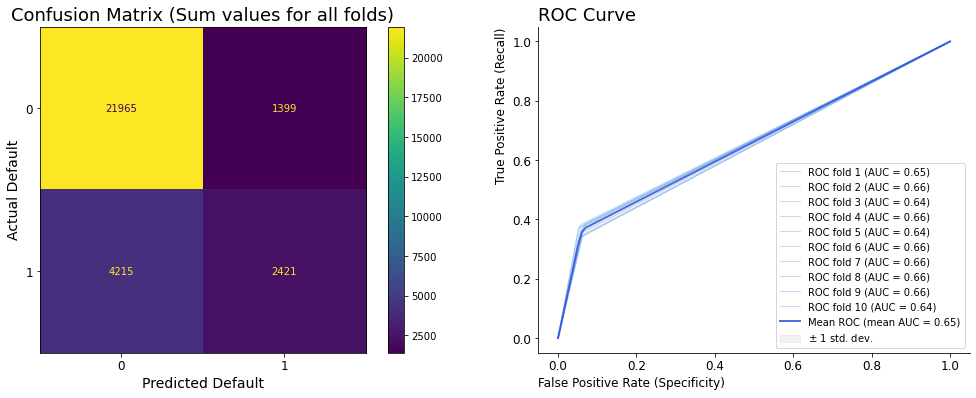

Métrics:

Mean Recall = 0.365 | Recall Std = 0.02
Mean Precision = 0.634 | Precision Std = 0.02
Mean F1 = 0.463 | F1 Std = 0.02
Mean AUC = 0.652 | AUC Std = 0.01


In [8]:
# Removing categorical features and target 
X  = default_credit_card.loc[:,['limit_bal'] + default_credit_card.columns[5:23].tolist()]
# Geting target
y = default_credit_card.default_payment_next_month

# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

#Evaluating Baseline with raw data (Randon Forest classifier)
baseline_metrics = evaluate_random_forest(X_train_list, X_test_list, y_train_list,y_test_list)

***As expected, we had really bad results!*** After all, we simply created a model with the raw data, without any treatment. 

let's start dealing with the imbalance data problem and see how much we can improve the results


## Treating Imbalance

To combat imbalanced we will try four different techniques:

+ Under-sampling (resampling data)
+ Over-sampling (resampling data)
+ SMOTE (Generate Synthetic Samples)
+ SMOTE + Under-Sampling

### Under-Sampling

Under-sampling consists in deleting data from the majority class until we have balanced data, i.e, an equal number of examples for each class.

A potential problem with this technique is that if the imbalance is severe, a lot of data will be deleted, which can make the differences between classes more difficult to learn.

To implement this technique we will use ***RandomUnderSampler***.  From [documentation](https://imbalanced-learn.org/stable/under_sampling.html) we found the definition: "RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes"

let's develop a function to apply Under-sampling in n k-folds, so we can include this processing in our model pipeline, ***applying only in training data***.

In [9]:
def undersampling_kfolds(X_train_list,y_train_list):
    
    """return n training data folds with Under-sampling technique applied
    * It is very important to apply this processing only in the training data
    * this way, our validation data will remain faithful to a real production situation,avoiding overfitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    """
    
    # Define undersample strategy
    # “majority” will undersample the majority class determined by the class with the largest number of examples.  
    undersample = RandomUnderSampler(sampling_strategy='majority',random_state = 42)

    # Process training data and append resampled folds to lists
    X_under_resampled_list, y_under_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_under_resampled, y_under_resampled = undersample.fit_resample(X_train, y_train)
        X_under_resampled_list.append(X_under_resampled)
        y_under_resampled_list.append(y_under_resampled)
        
    return X_under_resampled_list,y_under_resampled_list
                                              

***Evaluation Pipeline:***

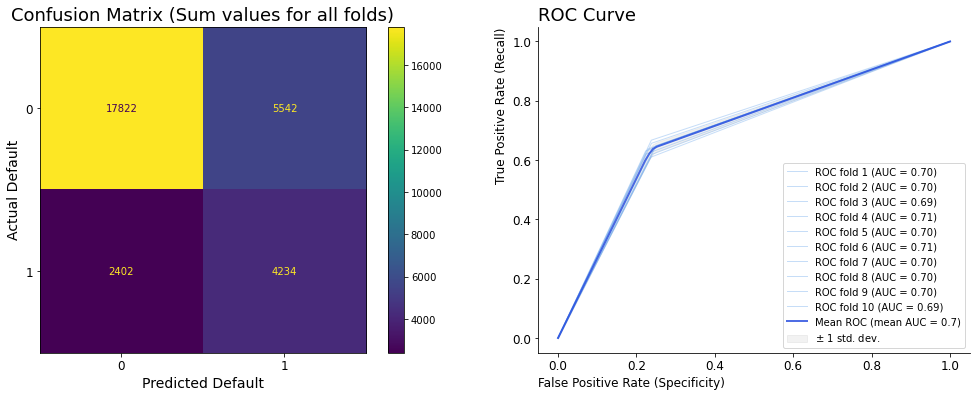

Métrics:

Mean Recall = 0.638 | Recall Std = 0.02
Mean Precision = 0.433 | Precision Std = 0.01
Mean F1 = 0.516 | F1 Std = 0.01
Mean AUC = 0.7 | AUC Std = 0.01


In [10]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling Undersampling ONLY IN TRAING DATA
X_under_resampled_train_list,y_under_resampled_train_list = undersampling_kfolds(X_train_list,y_train_list)

#Evaluating Model with Undersampling treatment (Randon Forest classifier)
under_metrics  =evaluate_random_forest(X_under_resampled_train_list, X_test_list, y_under_resampled_train_list,y_test_list)

***For sure we lost a good amount of data, but now we have balanced data. Because of that, we achieved a great improvement over our baseline!***

Although we noticed a small improvement in the ROC Curve (mean AUC went from 0.65 to 0.7) ***the biggest improvement can be seen in the Recall, which went from 0.37 to 0.64!*** This means that we are having a lot less false negative. 

However, the loss of data seems to have had a negative impact on the model, as the improvement in other metrics was very subtle. Let's try other techniques that can alleviate this problem. 

### Over-Sampling

Over-sampling has a similar principle to under-sampling, but instead of deleting data, we will duplicate examples from the minority class. 

A potential problem with this technique is that it may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples.
  
To implement this technique we will use RandomOverSampler class, to randomly duplicate samples of minority class

let's develop a function to apply Over-sampling in n k-folds, so we can include this processing in our model pipeline, ***applying only in training data***.

In [11]:
def oversampling_kfolds(X_train_list,y_train_list):
    
    """return n training data folds with over-sampling technique applied
    * It is very important to apply this processing only in the training data
    * this way, our validation data will not be contaminated,avoiding overfitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    """
    
    # Define oversampling strategy
    # “minority” will automatically balance the minority class with majority class
    oversample = RandomOverSampler(sampling_strategy='minority',random_state = 42)

    # Process training data and append resampled folds to lists
    X_over_resampled_list, y_over_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_over_resampled, y_over_resampled = oversample.fit_resample(X_train, y_train)
        X_over_resampled_list.append(X_over_resampled)
        y_over_resampled_list.append(y_over_resampled)
        
    return X_over_resampled_list,y_over_resampled_list
                                              

***Evaluation Pipeline:***

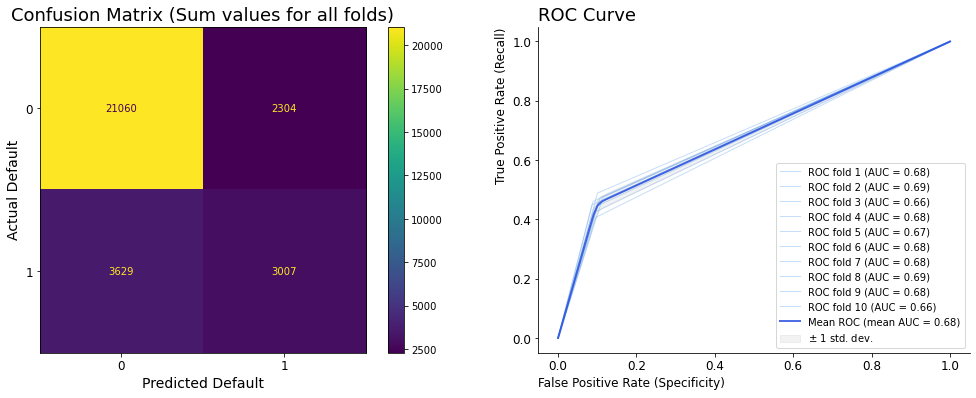

Métrics:

Mean Recall = 0.453 | Recall Std = 0.02
Mean Precision = 0.567 | Precision Std = 0.02
Mean F1 = 0.503 | F1 Std = 0.02
Mean AUC = 0.677 | AUC Std = 0.01


In [12]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling Oversampling ONLY IN TRAING DATA
X_over_resampled_train_list,y_over_resampled_train_list = oversampling_kfolds(X_train_list,y_train_list)

#Evaluating Model with Oversampling treatment (Randon Forest classifier)
over_metrics = evaluate_random_forest(X_over_resampled_train_list, X_test_list, y_over_resampled_train_list,y_test_list)

***We solved the imbalance problem, but we have a lot of repeated data***

We were still able to improve our baseline, but comparing with under-sampling, we have a significant ***worsening in the Recall, going from 0.64 to 0.45.***

On the other hand, we have an ***improvement in Precision, going from 0.43 to 0.57***

This show that using oversampling or under-sampling represents a ***trade off between Recall and Precision***, i.e, using under-sampling we choose to prioritize the reduction of false negative rate, and using oversampling we choose to prioritize correct positive predictions.


In the metrics section, we have already established that speaking about credit card default, predicting a false negative can have serious consequences for the business, that is, in our case, recall is more important than precision, and therefore the ***under-sampling technique is more appropriate then oversampling.***

Lets try the SMOTE resampling technique to see if we can find a result that matches a good Recall and a good precision.

### SMOTE

Just like the oversampling technique, SMOTE (Synthetic Minority Oversampling Technique) intends to oversample the minority class. But instead of duplicating data, SMOTE creates new data from the existing examples. 

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

let's try it out!

In [13]:
def smote_kfolds(X_train_list,y_train_list):
    
    """return n training data folds with smotesampling technique applied
    * It is very important to apply this processing only in the training data
    * this way, our validation data will not be contaminated,avoiding overfitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    """
    
    # Define SMOTE
    smote_oversample = SMOTE(random_state = 42)

    # Process training data and append resampled folds to lists
    X_smote_resampled_list, y_smote_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_smote_resampled, y_smote_resampled = smote_oversample.fit_resample(X_train, y_train)
        X_smote_resampled_list.append(X_smote_resampled)
        y_smote_resampled_list.append(y_smote_resampled)
        
    return X_smote_resampled_list,y_smote_resampled_list
                                              

***Evaluation Pipeline:***

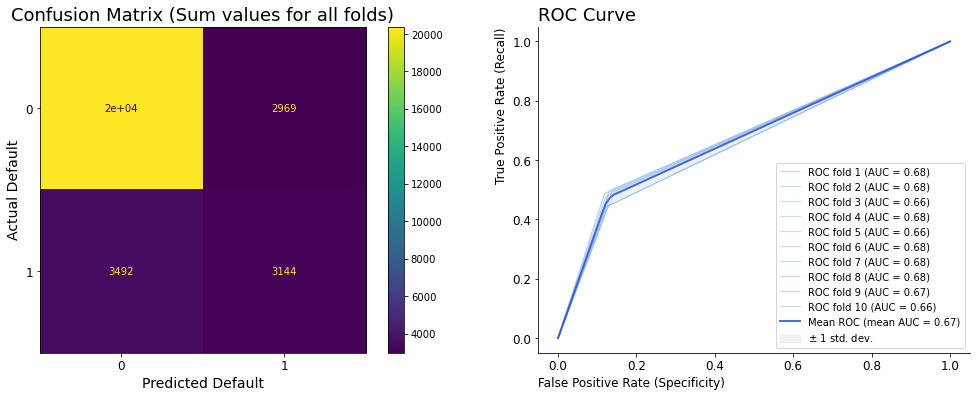

Métrics:

Mean Recall = 0.474 | Recall Std = 0.02
Mean Precision = 0.514 | Precision Std = 0.02
Mean F1 = 0.493 | F1 Std = 0.02
Mean AUC = 0.673 | AUC Std = 0.01


In [14]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling SMOTE Oversampling ONLY IN TRAING DATA
X_smote_resampled_train_list,y_smote_resampled_train_list = smote_kfolds(X_train_list,y_train_list)

#Evaluating Model with SMOTE treatment (Randon Forest classifier)
smote_metrics = evaluate_random_forest(X_smote_resampled_train_list, X_test_list, y_smote_resampled_train_list,y_test_list)

in general, we observed a small worsening in the results

Comparing to oversampling, there is a tread off between Recall (small improvment) and precision (small worsening). 

Considering that mean AUC and mean F1 are worse or equal to both, oversampling and undersampling, this small tread off is not paying off. 

***The best technique for our case still is undersampling***

### SMOTE + Under-Sampling

In [the original SMOTE paper](https://arxiv.org/pdf/1106.1813.pdf), the best results were obtained by using a  Under-sampling and SMOTE Combination. 

This is because applying SMOTE to achieve an equal balance with the majority class is not necessarily the best case for the classifier. Thus, we can under-sample the majority to different percentages of the original majority class (say 25%, 50%, 75%) , and then, apply SMOTE to minority samples.

let's try it out!

In [15]:
def smote_undersampling_kfolds(X_train_list,y_train_list,under_rate):
    
    """return n training data folds with a combination of SMOTE and Under-Sampling technique applied
    * It is very important to apply this processing only in the training data
    * this way, our validation data will not be contaminated,avoiding overfitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    under_rate -- The rate of Under-Sampling strategy
    """
 
    undersample = RandomUnderSampler(sampling_strategy = under_rate,random_state = 42)
    smote_oversample = SMOTE(random_state = 42)

    # Process training data and append resampled folds to lists
    X_smote_resampled_list, y_smote_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_under_resampled, y_under_resampled = undersample.fit_resample(X_train, y_train)
        X_smote_under_resampled, y_smote_under_resampled = smote_oversample.fit_resample(X_under_resampled, y_under_resampled)
        
        
        X_smote_resampled_list.append(X_smote_under_resampled)
        y_smote_resampled_list.append(y_smote_under_resampled)
        
    return X_smote_resampled_list,y_smote_resampled_list
                                              

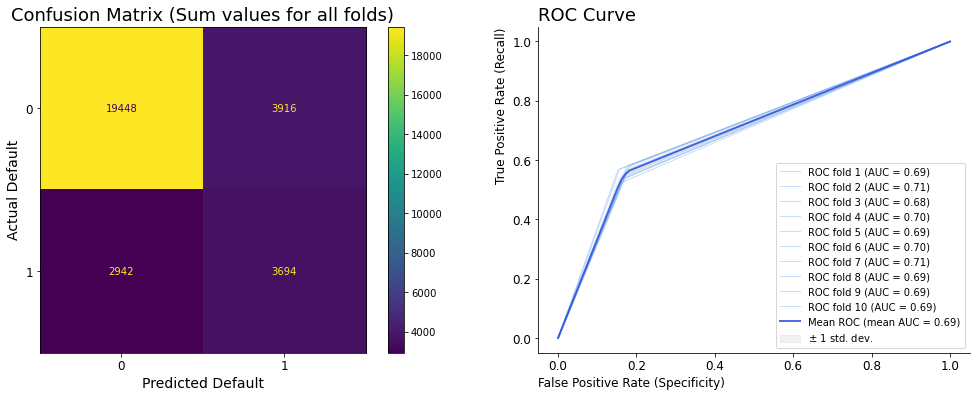

Métrics:

Mean Recall = 0.557 | Recall Std = 0.02
Mean Precision = 0.486 | Precision Std = 0.01
Mean F1 = 0.519 | F1 Std = 0.01
Mean AUC = 0.695 | AUC Std = 0.01


In [16]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling SMOTE Oversampling ONLY IN TRAING DATA
X_smote_under_train_list,y_smote_under_train_list = smote_undersampling_kfolds(X_train_list,y_train_list,under_rate = 0.5)

#Evaluating Model with SMOTE treatment (Randon Forest classifier)
smote_under_metrics = evaluate_random_forest(X_smote_under_train_list, X_test_list, y_smote_under_train_list,y_test_list)

although we tried a number of different values for sampling_strategy, ***we were unable to obtain a significant overall improvement (AUC and F1).***

However, ***we were able to achieve a great balance between Precision and Recall***, witch can be very usefull in some projects.

Unfortunately, this is not our case. We know that Recall is the metric that will have the biggest impact on the business, and should be prioritized. 

So in our case, ***Under-Sampling is the best choice between all tested technique!***

# Feature selection and engineering

## Preparing

***Now that we defined how to treat imbalance (by using under-sampling) lets start doing some Feature selection.***

Until now, we used only the continuous variables without any treatment to build the models. Now, its time to test the categorical features and the previously created feature (steps included in the notebook "eda_and_feature_engineering") to see the impact on metrics. 

As stated in the introduction, we chose to use an iterative method to select features, and we will focus in two possibilities:
+ Test feature without any treatment
+ Process categorical Features with One-Hot Encoding

Before we start, now that we have defined how to handle the imbalance, we can define a simple function for the model pipeline, so we will avoid repeating this step in each tested feature

In [17]:
def evaluation_pipeline(X,y,model = 'randomforest',
                        n_est = 100,l_rate = 0.05,max_d = None, min_s_leaf = 1, min_s_split = 2,
                        charts = 1,metrics =1, val =1):
    
    """ Show Model metrics and plot relevant charts
    The pipeline will:
    *Receive the features and target as keywords
    *Use StratifiedKFold cross validation technique to divide the data in 10 (or n) folds
    *Pre processing the training data (isolating test data to avoid overfitting) with Under-Sampling
    *Build a Randon Forest Classifier model for each fold and make predictions with the validation data. 
    *Calculate metrics for each fold using our pre defined Metrics class, and display a summary of the results.
    
    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    model -- what model should be used, can be: 'randomforest' or 'xgboost' (default = 'randomforest')
    n_est -- n_estimators hyperparameter (default = 100)
    max_d -- n_estimators hyperparameter (default = None)
    min_s_leaf -- min_samples_leaf hyperparameter (default = 1)
    min_s_split -- min_samples_split hyperparameter (default = 2)
    l_rate -- Learning rate for XGBoost model (default 0.05)
    charts -- define whether the charts will be displayed (default = 1)
    val -- define if model will be tested with validadion data - 1; or with training data - 0 (default 1)
    """
    
    # Spliting data into training and validation k-folds and appending folds to lists
    X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

    # Appling Undersampling ONLY IN TRAING DATA
    X_under_resampled_train_list,y_under_resampled_train_list = undersampling_kfolds(X_train_list,y_train_list)

    #Evaluating Model with Undersampling treatment 
    # Randon Forest classifier
    if model == 'randomforest':
        metrics_list = evaluate_random_forest(X_under_resampled_train_list,X_test_list,
                                              y_under_resampled_train_list,y_test_list,
                                              n_est = n_est,max_d = max_d,min_s_leaf=min_s_leaf,min_s_split=min_s_split,
                                              charts =charts,metrics = metrics, val = val)
    # XGBoost Classifier  
    elif model == 'xgboost':        
        metrics_list = evaluate_xgboost(X_under_resampled_train_list,X_test_list,
                                        y_under_resampled_train_list,y_test_list,
                                        n_est = n_est, l_rate= l_rate,max_d = max_d,
                                        charts =charts,metrics = metrics, val = val)
        
    else:
        return print("Plese chose a valid model:'randomforest' or 'xgboost'")

    return metrics_list

In [18]:
def one_hot_encoding(df, serie_to_encode):
    
    """ Encode a categorical feature and append it to the main df

    Keyword arguments:
    df -- DataFrame to append encoded feature
    serie_to_encode -- Categorical feature to encode and append
    """
    
    if len(serie_to_encode) != len(df):
        return print('Serie to encode must have same len of df')
    
    data = np.array(serie_to_encode)
    data = np.reshape(data,(-1, 1))
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    onehot = encoder.fit_transform(data)
    onehot_df = pd.DataFrame(onehot, columns=encoder.get_feature_names_out())

    encoded_df = pd.concat([df,onehot_df], axis =1)
    
    return encoded_df

In [19]:
# Lets define a "raw_X" only with continuous variables (the ones that we were working until now) 

# Removing categorical features and target 
raw_X  = default_credit_card.loc[:,['limit_bal'] + default_credit_card.columns[5:23].tolist()]
# Geting target
y = default_credit_card.default_payment_next_month

raw_X.columns

Index(['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6'],
      dtype='object')

***please keep in mind that on the model treated with Under-Sampling we got:***

+ Mean Recall = 0.638
+ Mean Precision = 0.433
+ Mean F1 = 0.516
+ Mean AUC = 0.7

## Sex

In [20]:
# testing Variable Sex

# Adding feature
raw_X_sex = raw_X.copy()
raw_X_sex['sex'] = default_credit_card['sex']

# Testing
sex_metrics = evaluation_pipeline(raw_X_sex,y, charts = 0)

Métrics:

Mean Recall = 0.641 | Recall Std = 0.02
Mean Precision = 0.436 | Precision Std = 0.01
Mean F1 = 0.519 | F1 Std = 0.01
Mean AUC = 0.703 | AUC Std = 0.01


In [21]:
raw_X_sex_encoded = one_hot_encoding(raw_X, default_credit_card['sex'])

# Testing
sex_encoded_metrics = evaluation_pipeline(raw_X_sex_encoded,y, charts = 0)

Métrics:

Mean Recall = 0.638 | Recall Std = 0.02
Mean Precision = 0.435 | Precision Std = 0.01
Mean F1 = 0.517 | F1 Std = 0.01
Mean AUC = 0.701 | AUC Std = 0.01


We see that both, raw and the encoded variables, improved the performance of the model. However, ***the raw feature showed better results***, so we will keep it! 

In [22]:
# Adding sex feature to final_X

final_X = raw_X.copy()
final_X['sex'] = default_credit_card['sex']
final_X.columns

Index(['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6', 'sex'],
      dtype='object')

## Education

In [23]:
# testing Variable education

# Adding feature
raw_X_education = raw_X.copy()
raw_X_education['education'] = default_credit_card['education']

# Testing
education_metrics = evaluation_pipeline(raw_X_education,y, charts = 0)

Métrics:

Mean Recall = 0.637 | Recall Std = 0.02
Mean Precision = 0.433 | Precision Std = 0.01
Mean F1 = 0.515 | F1 Std = 0.01
Mean AUC = 0.7 | AUC Std = 0.01


In [24]:
raw_X_education_encoded = one_hot_encoding(raw_X, default_credit_card['education'])

# Testing
education_encoded_metrics = evaluation_pipeline(raw_X_education_encoded,y, charts = 0)

Métrics:

Mean Recall = 0.635 | Recall Std = 0.02
Mean Precision = 0.433 | Precision Std = 0.01
Mean F1 = 0.515 | F1 Std = 0.01
Mean AUC = 0.699 | AUC Std = 0.01


***In both cases we got worse results! so, we will not use the education feature***

## Marriage

In [25]:
# testing Variable marriage

# Adding feature
raw_X_marriage = raw_X.copy()
raw_X_marriage['marriage'] = default_credit_card['marriage']

# Testing
marriage_metrics = evaluation_pipeline(raw_X_marriage,y, charts = 0)

Métrics:

Mean Recall = 0.64 | Recall Std = 0.02
Mean Precision = 0.434 | Precision Std = 0.01
Mean F1 = 0.517 | F1 Std = 0.01
Mean AUC = 0.701 | AUC Std = 0.01


In [26]:
raw_X_marriage_encoded = one_hot_encoding(raw_X, default_credit_card['marriage'])

# Testing
marriage_encoded_metrics = evaluation_pipeline(raw_X_marriage_encoded,y, charts = 0)

Métrics:

Mean Recall = 0.64 | Recall Std = 0.02
Mean Precision = 0.437 | Precision Std = 0.01
Mean F1 = 0.519 | F1 Std = 0.01
Mean AUC = 0.703 | AUC Std = 0.01


***The encoded feature showed the best improvement, lets add it to the final_X***

In [27]:
final_X = one_hot_encoding(final_X, default_credit_card['marriage'])

# Renaming marrige encoded features
final_X.rename(columns = {'x0_0':'marriage_0', 'x0_1':'marriage_1', 'x0_2':'marriage_2', 'x0_3':'marriage_3'},inplace = True)
final_X.columns

Index(['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6', 'sex', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'],
      dtype='object')

## Age

In this case, as we have many categories, ***it won't make sense to use one-hot encoding***. However, in the notebook "eda_and_feature_engineering" we developed a feature based on age ranges (age_range_int), which we also be tested here

In [28]:
# testing Variable age

# Adding feature
raw_X_age = raw_X.copy()
raw_X_age['age'] = default_credit_card['age']

# Testing
age_metrics = evaluation_pipeline(raw_X_age,y, charts = 0)

Métrics:

Mean Recall = 0.634 | Recall Std = 0.02
Mean Precision = 0.436 | Precision Std = 0.01
Mean F1 = 0.517 | F1 Std = 0.01
Mean AUC = 0.7 | AUC Std = 0.01


In [29]:
# testing Variable age_range_int

# Adding feature
raw_X_age_range_int = raw_X.copy()
raw_X_age_range_int['age_range_int'] = default_credit_card['age_range_int']

# Testing
age_range_int_metrics = evaluation_pipeline(raw_X_age_range_int,y, charts = 0)

Métrics:

Mean Recall = 0.639 | Recall Std = 0.02
Mean Precision = 0.441 | Precision Std = 0.01
Mean F1 = 0.522 | F1 Std = 0.01
Mean AUC = 0.704 | AUC Std = 0.01


the "raw age" feature showed no improvement. But the age_range_int on the other hand ***showed the greatest improvement among all the categorical features tested!!***

**Our work with feature engineering definitely paid off!** please check the notebook "eda_and_feature_engineering" for more details on the development of this feature.

Lets add it to the final_x

In [30]:
final_X['age_range_int'] = default_credit_card['age_range_int']

final_X.columns

Index(['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6', 'sex', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3', 'age_range_int'],
      dtype='object')

## Previously created continuous features

In the notebook "eda_and_feature_engineering" we created three continuous features that will be tested here:
+ sum_pay
+ mean_bill
+ mean_pay_amt

In [31]:
# testing Variable sum_pay

# Adding feature
raw_X_sum_pay = raw_X.copy()
raw_X_sum_pay['sum_pay'] = default_credit_card['sum_pay']

# Testing
sum_pay_metrics = evaluation_pipeline(raw_X_sum_pay,y, charts = 0)

Métrics:

Mean Recall = 0.638 | Recall Std = 0.02
Mean Precision = 0.435 | Precision Std = 0.01
Mean F1 = 0.518 | F1 Std = 0.01
Mean AUC = 0.702 | AUC Std = 0.01


***We have an improvement, feature approved***

In [32]:
final_X['sum_pay'] = default_credit_card['sum_pay']

In [33]:
# testing Variable mean_bill

# Adding feature
raw_X_mean_bill = raw_X.copy()
raw_X_mean_bill['mean_bill'] = default_credit_card['mean_bill']

# Testing
mean_bill_metrics = evaluation_pipeline(raw_X_mean_bill,y, charts = 0)

Métrics:

Mean Recall = 0.639 | Recall Std = 0.02
Mean Precision = 0.43 | Precision Std = 0.01
Mean F1 = 0.514 | F1 Std = 0.01
Mean AUC = 0.699 | AUC Std = 0.01


***We have a small worsening, feature disapproved***

In [34]:
# testing Variable mean_pay_amt

# Adding feature
raw_X_mean_pay_amt = raw_X.copy()
raw_X_mean_pay_amt['mean_pay_amt'] = default_credit_card['mean_pay_amt']

# Testing
mean_pay_amt_metrics = evaluation_pipeline(raw_X_mean_pay_amt,y, charts = 0)

Métrics:

Mean Recall = 0.637 | Recall Std = 0.02
Mean Precision = 0.431 | Precision Std = 0.01
Mean F1 = 0.514 | F1 Std = 0.01
Mean AUC = 0.699 | AUC Std = 0.01


***We have a small worsening, feature disapproved***

## Final feature evaluation

We selected the features that improved model performance and removed those that worsened. let's now see how the model performs with all the selected features!

In [35]:
# quick look at which features we kept
final_X.columns

Index(['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6', 'sex', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3', 'age_range_int', 'sum_pay'],
      dtype='object')

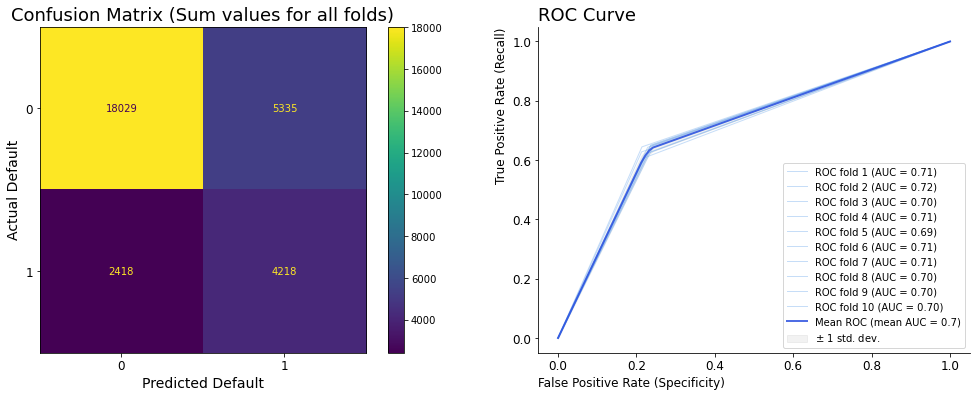

Métrics:

Mean Recall = 0.636 | Recall Std = 0.01
Mean Precision = 0.442 | Precision Std = 0.01
Mean F1 = 0.521 | F1 Std = 0.01
Mean AUC = 0.704 | AUC Std = 0.01


In [36]:
evaluation_metrics = evaluation_pipeline(final_X,y)

Although we noticed a small improvement in F1 and AUC, ***adding the features almost didn't make any impact.*** Showing that the continuous features related to the payment history are the most relevant!

Lets try to improve our metrics with hyperparameter tuning

# Model selection and hyperparameter tuning

## Model selection (grid search)

***To select the best model, lets first find its best hyperparameters with grid search, and then, we can see which model performs better.***

***Please note that the metric we need to focus on to improve is Recall, so we will focus our grid search on this metric***

In [37]:
def random_forest_grid_search(X,y):
    
    """Return the best hyperparameters of pre-defined search space for a Random Forest Model 
    * We will focus on Recall optimization

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    """
    
    t1_start = perf_counter()
    random_forest_search_space = {'n_estimators':[3,5,10,15,25,50,75,100],
                                  'max_depth':[None,6,10,15,20,25], 
                                  'min_samples_leaf':[1,4,6,8,10,15],
                                  'min_samples_split':[1,2,4,6,8,10]}

    rfc = RandomForestClassifier(random_state=42)
    gs = GridSearchCV(rfc, param_grid=random_forest_search_space, 
                      scoring="recall", # The metric we need to focus on to reduce false negatives is Recall.
                      n_jobs=-2, cv=5, return_train_score=True)

    # Define undersample strategy
    undersample = RandomUnderSampler(sampling_strategy='majority',random_state = 42)
    X_under_resampled, y_under_resampled = undersample.fit_resample(X, y)

    gs.fit(X_under_resampled, y_under_resampled)

    t1_stop = perf_counter()
    print(f'Grid search time: {round((t1_stop-t1_start)/60,2)}min')
    
    return gs.best_params_

In [38]:
def xgboost_grid_search(X,y):
        
    """Return the best hyperparameters of pre-defined search space for a XGBoost Model 
    * We will focus on Recall optimization

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    """
    
    t1_start = perf_counter()
    
    xgboost_search_space = {'n_estimators':[25,50,75,100,150],
                            'max_depth':[None,6,10,15,20,25],
                            'learning_rate':[0.02,0.04,0.05,0.06,0.07,0.1]}

    xgb = xgboost.XGBClassifier(random_state=42, eval_metric='mlogloss')
    gs = GridSearchCV(xgb, param_grid=xgboost_search_space, 
                      scoring="recall", # The metric we need to focus on to reduce false negatives is Recall.
                      n_jobs=-2, cv=5, return_train_score=True)

    # Define undersample strategy
    undersample = RandomUnderSampler(sampling_strategy='majority',random_state = 42)
    X_under_resampled, y_under_resampled = undersample.fit_resample(X, y)

    gs.fit(X_under_resampled, y_under_resampled)

    t1_stop = perf_counter()
    print(f'Grid search time: {round((t1_stop-t1_start)/60,2)}min')
    
    return gs.best_params_

In [39]:
best_params_random_forest = random_forest_grid_search(final_X,y)
best_params_random_forest

Grid search time: 17.14min


{'max_depth': 20,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 5}

In [40]:
best_params_xgboost = xgboost_grid_search(final_X,y)
best_params_xgboost

Grid search time: 20.25min


{'learning_rate': 0.02, 'max_depth': 20, 'n_estimators': 25}

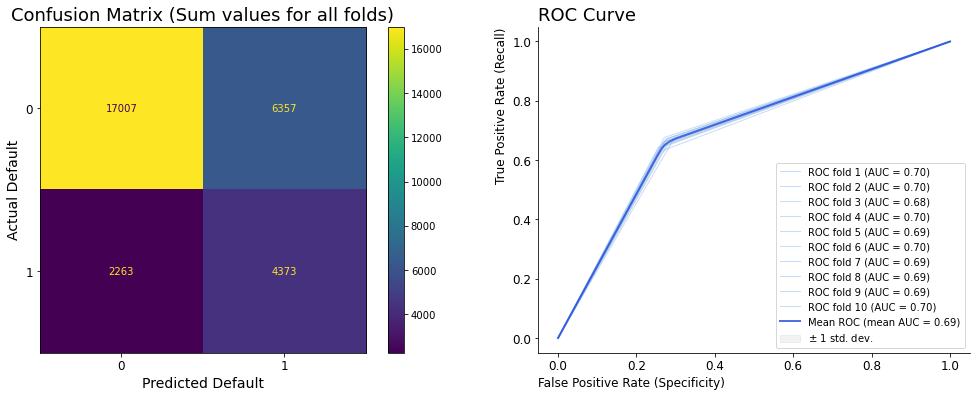

Métrics:

Mean Recall = 0.659 | Recall Std = 0.01
Mean Precision = 0.408 | Precision Std = 0.01
Mean F1 = 0.504 | F1 Std = 0.01
Mean AUC = 0.693 | AUC Std = 0.01


In [41]:
# Evaluating Random Forest with best hyperparameters

random_forest_final_metrics = evaluation_pipeline(final_X,y,model = 'randomforest',
                                                  n_est = 5,max_d = 20, min_s_leaf = 8, min_s_split = 2)

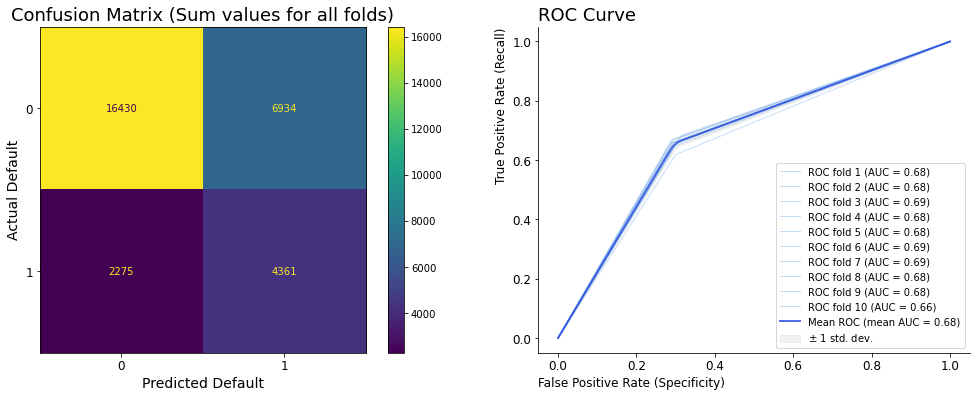

Métrics:

Mean Recall = 0.657 | Recall Std = 0.02
Mean Precision = 0.386 | Precision Std = 0.01
Mean F1 = 0.486 | F1 Std = 0.01
Mean AUC = 0.68 | AUC Std = 0.01


In [42]:
# Evaluating XGBoost with best hyperparameters

xgboost_final_metrics = evaluation_pipeline(final_X,y,model = 'xgboost',
                                            n_est = 25,max_d = 20,l_rate = 0.02)

***with the optimization of the hyperparameters we managed to improve the recall considerably, from 0.636 to 0.659***

Both models performed similarly, but the random forest showed a slight advantage,especially in F1 and AUC. for that reason, ***we will choose the Random Forest Classifier Model***

## Evaluating the learning curve

In [43]:
def learning_curve(X,y):
    
    """Calculate all our metrics for training and validation data for different samples size.
    * Return a DataFrame with results
    * Uses stratify Train test split to get samples of multiple sizes.
    * DataFrame will be used to build the learning curve

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    """
    
    final_df = pd.DataFrame() # used to concatenate results

    for test_size in range(2,102,2): # increase samples qnt. in 5%  each loop
        
        test_size_f =  test_size/100
        # We will use train test split to guarantee that data will be stratify
        if test_size_f != 1:
            X_, X_sample, y_, y_sample = train_test_split(final_X, np.array(y),
                                                        test_size= test_size_f,stratify = y, random_state=42)
            
        # K folds needs a reseted index
        y_sample_df = pd.DataFrame({'y':y_sample})
        X_sample.reset_index(drop = True, inplace = True)
        
        if test_size_f == 1:
            X_sample = X.copy()
            y_sample_df = pd.DataFrame({'y':y.values})
        
        # Validation Metrics
        # Random Forest Classifier
        metrics_list_random_val = evaluation_pipeline(X_sample,y_sample_df['y'],model = 'randomforest',
                                                      n_est = 5,max_d = 20, min_s_leaf = 8, min_s_split = 2, # hyperparameter
                                                      metrics = 0)
        # Creating Random Forest Validation Metrics DataFrame
        df_random_val = classification.mean_metrics(metrics_list_random_val)
        # Renaming columns to add vadidation reference
        for col in df_random_val.columns:
            df_random_val.rename(columns ={col:col + ' (Validation)'}, inplace = True)
        

        # Training Metrics
        # Random Forest
        metrics_list_random_train = evaluation_pipeline(X_sample,y_sample_df['y'],model = 'randomforest',
                                                        n_est = 5,max_d = 20, min_s_leaf = 8, min_s_split = 2, # hyperparameter
                                                        metrics = 0,
                                                        val = 0) # val = 0 will make the model to be tested with training dasa
        # Creating Random Forest Trining Metrics DataFrame
        df_random_train = classification.mean_metrics(metrics_list_random_train)
        # Renaming columns to add vadidation reference
        for col in df_random_train.columns:
            df_random_train.rename(columns ={col:col +' (Training)'}, inplace = True)
        # Add infos concerning to this loop
        df_random_train['Model'] = ['Random Forest']
        df_random_train['Data Size'] = [len(X_sample)]
        
        # merging information of training and validation metrics
        random_forest_df = pd.concat([df_random_val,df_random_train], axis = 1)
        
        # Concatenating results
        final_df = pd.concat([final_df,random_forest_df])
    
    # Reorganizing df
    final_df2 = final_df.loc[:,['Model','Data Size'] + final_df.columns[:-2].tolist()]
    final_df2.reset_index(drop = True, inplace = True)
    
    return final_df2

In [44]:
learning_curve_df = learning_curve(final_X,y)  

In [45]:
learning_curve_df.head(3)

,Model,Data Size,Mean Recall (Validation),Mean Precision (Validation),Mean F1 (Validation),Mean AUC (Validation),Mean Recall (Training),Mean Precision (Training),Mean F1 (Training),Mean AUC (Training)
0,Random Forest,600,0.564,0.347,0.428,0.632,0.728,0.839,0.779,0.794
1,Random Forest,1200,0.660,0.355,0.460,0.659,0.784,0.789,0.786,0.787
2,Random Forest,1800,0.671,0.365,0.472,0.670,0.803,0.799,0.801,0.800


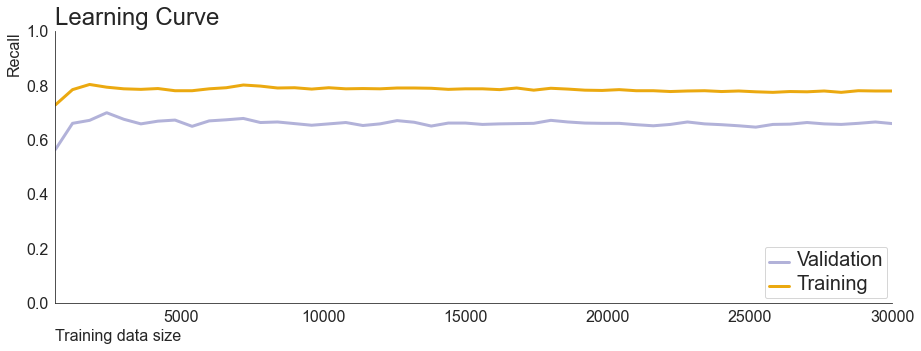

In [52]:
# Vizualizing learning curve

sns.set_style('white')
fig,ax1 = plt.subplots(figsize=(15,5))

sns.lineplot(x=learning_curve_df['Data Size'],
            y=learning_curve_df['Mean Recall (Validation)'],
            color ='#b2b2d9', label = 'Validation',
            lw =3, ax = ax1)

sns.lineplot(x=learning_curve_df['Data Size'],
            y=learning_curve_df['Mean Recall (Training)'],
            color ='#eba910', label = 'Training',
            lw =3, ax = ax1)

ax1.set_title("Learning Curve",fontsize = 24, loc = 'left')
ax1.set_xlabel("Training data size",fontsize=16, loc = 'left')
ax1.set_ylabel("Recall",fontsize=16, loc ='top')
ax1.tick_params(labelsize=16)
plt.legend(loc = 'lower right')
plt.setp(ax1.get_legend().get_texts(), fontsize='20')
sns.despine()
plt.xlim(600,30000)
plt.ylim(0,1)
plt.show() 

The learning curve brings us some interesting insights:

+ The metrics became aprox. constant very quick, meaning that we have more data then we need to train the model. ***Thats probably why we had good results using Under-Sampling technique***
+ on training size greater than ~2000 we have a small and constant difference between training and validation metrics. ***It is a sign of good bias-variance trade-off, i.e, the model is not overfitting neither underfitting***


***Conclusion:***

We were able to build a good model, with a Mean Recall = 0.659 and a Mean AUC = 0.693, ***if we want to further improve our metrics, there is no point in adding more data, we must add more features or improve the existing ones***

***For learning purposes we covered:***

+ How to perform an EDA to understand the data 
+ How to create features (feature engineering) based on the performed EDA and business knowledge
+ Which metrics and visualizations are important for evaluating a classification model, and how to use then. 
+ How to treat imbalanced dataset with fours different techniques (Under-Sampling, Over-Sampling, SMOTE, SMOTE + Under-Sampling)
+ How to build a Random Forest Classifier and a XGBoost classifier model 
+ How to evaluate a classification model using Stratified K-Folds cross-validator and avoid data leakage
+ How to do hyperparameter tuning using Grid search
+ How to analyze model bias-variance trade-off with the learning curve